In [44]:
import numpy as np
from scipy import signal
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import matplotlib.style as style
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from itertools import product
from tqdm.notebook import tqdm
import datetime as dt
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae


style.use("seaborn-white")
plt.rc("figure", figsize=(20, 20))
plt.rc("font", size=20)
plt.rc("legend", fontsize=20)
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("../london_merged.csv", parse_dates=["timestamp"], index_col="timestamp")
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [28]:
chosen_vars = [
    df.cnt.diff(365*24).dropna(),
    df.t1.diff(365*24).dropna(),
    df.hum.diff(365*24).dropna(),
    df.wind_speed.diff(24).dropna().loc[dt.datetime(2016, 1, 5, 21):]
]
targets = chosen_vars[:2]

In [105]:
def plot_series(series, ax=plt):
    result = smt.stattools.adfuller(series)
    ax.plot(series, label=series.name)
    ax.plot(series.rolling(24*5, center=True).mean(), label='mean')
    ax.legend()
    ax.title.set_text(f"Augmented Dickey-Fuller test p-value for {series.name}: {result[1]}")

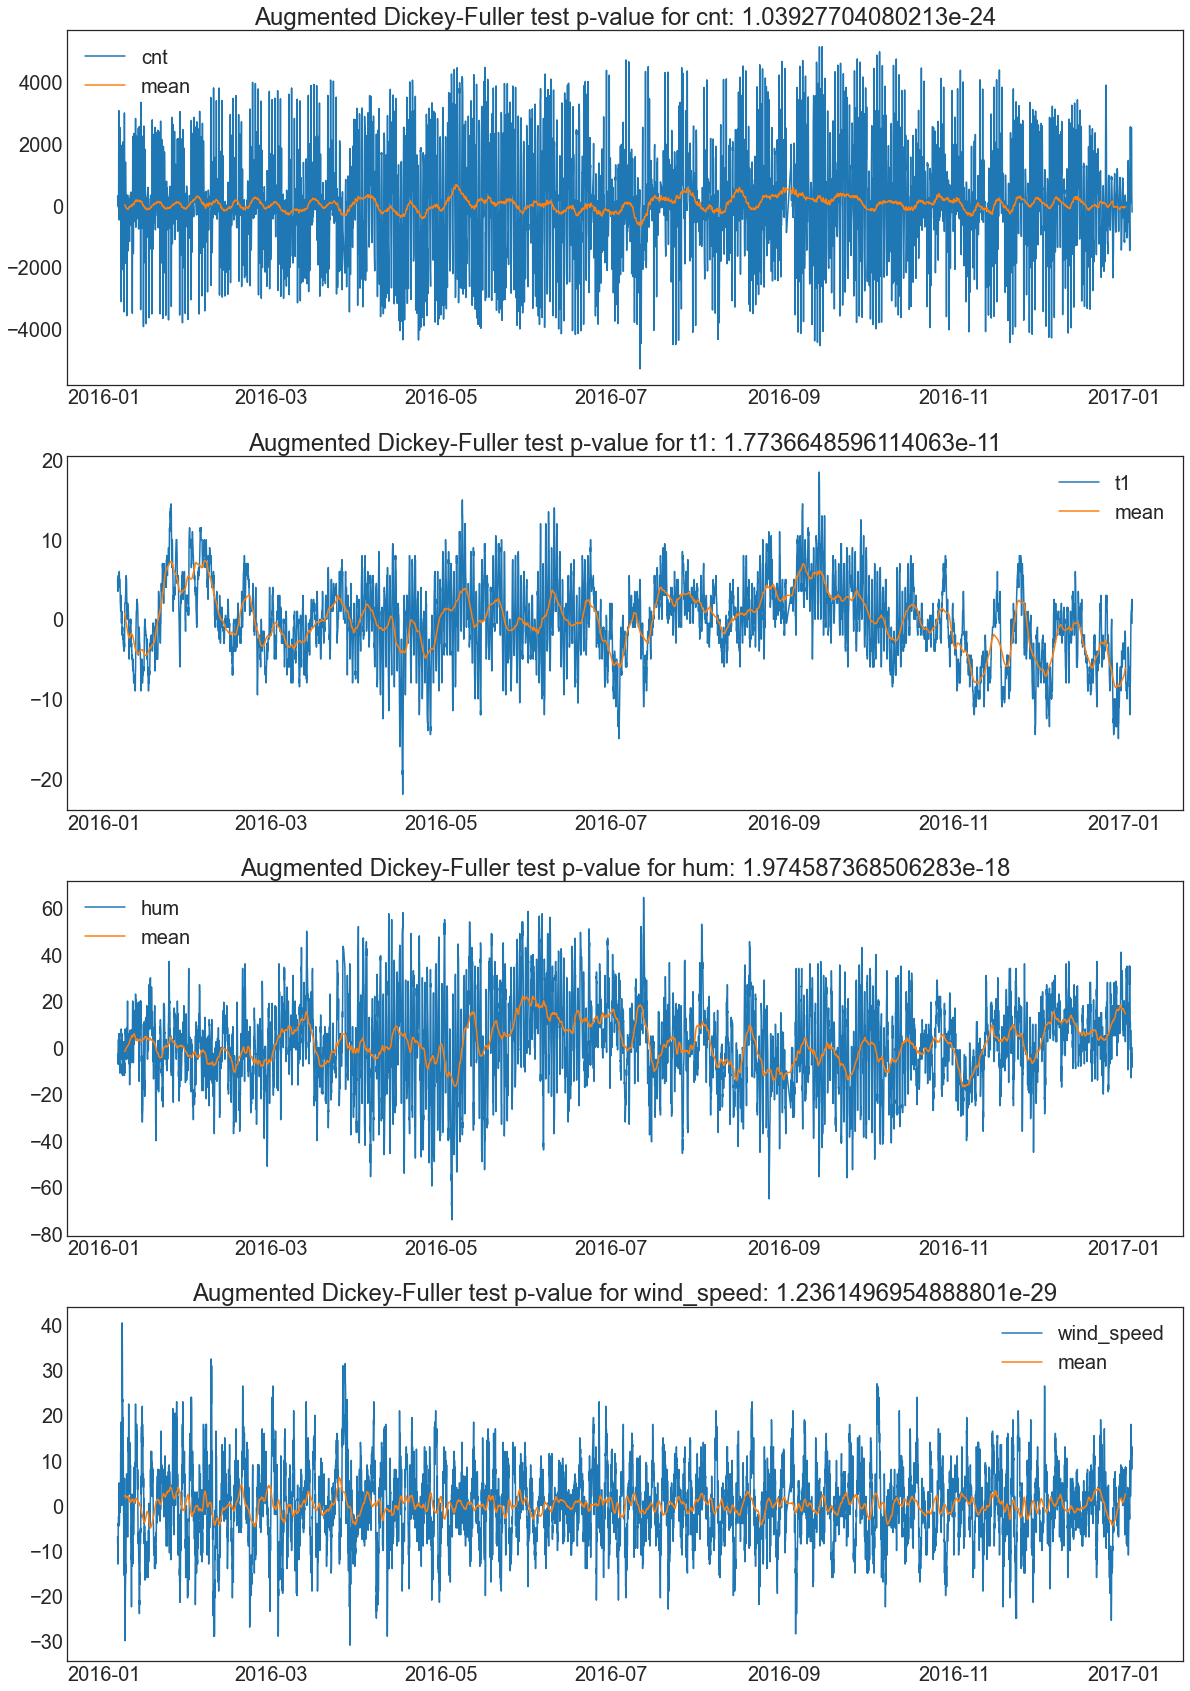

In [106]:
_, axes = plt.subplots(nrows=len(chosen_vars), figsize=(20, 30))
for i, ax in enumerate(axes.flatten()):
    plot_series(chosen_vars[i], ax=ax)

In [7]:
def plot_acovf(series, ax1, ax2, nlag=100):
    ax1.plot(smt.stattools.acovf(series), label=series.name)
    ax2.plot(smt.stattools.acovf(series, nlag=nlag), label=series.name)
    for x in range(24, nlag, 24):
        ax2.axvline(x, c='r', alpha=0.3)
    ax1.legend()
    ax2.legend()

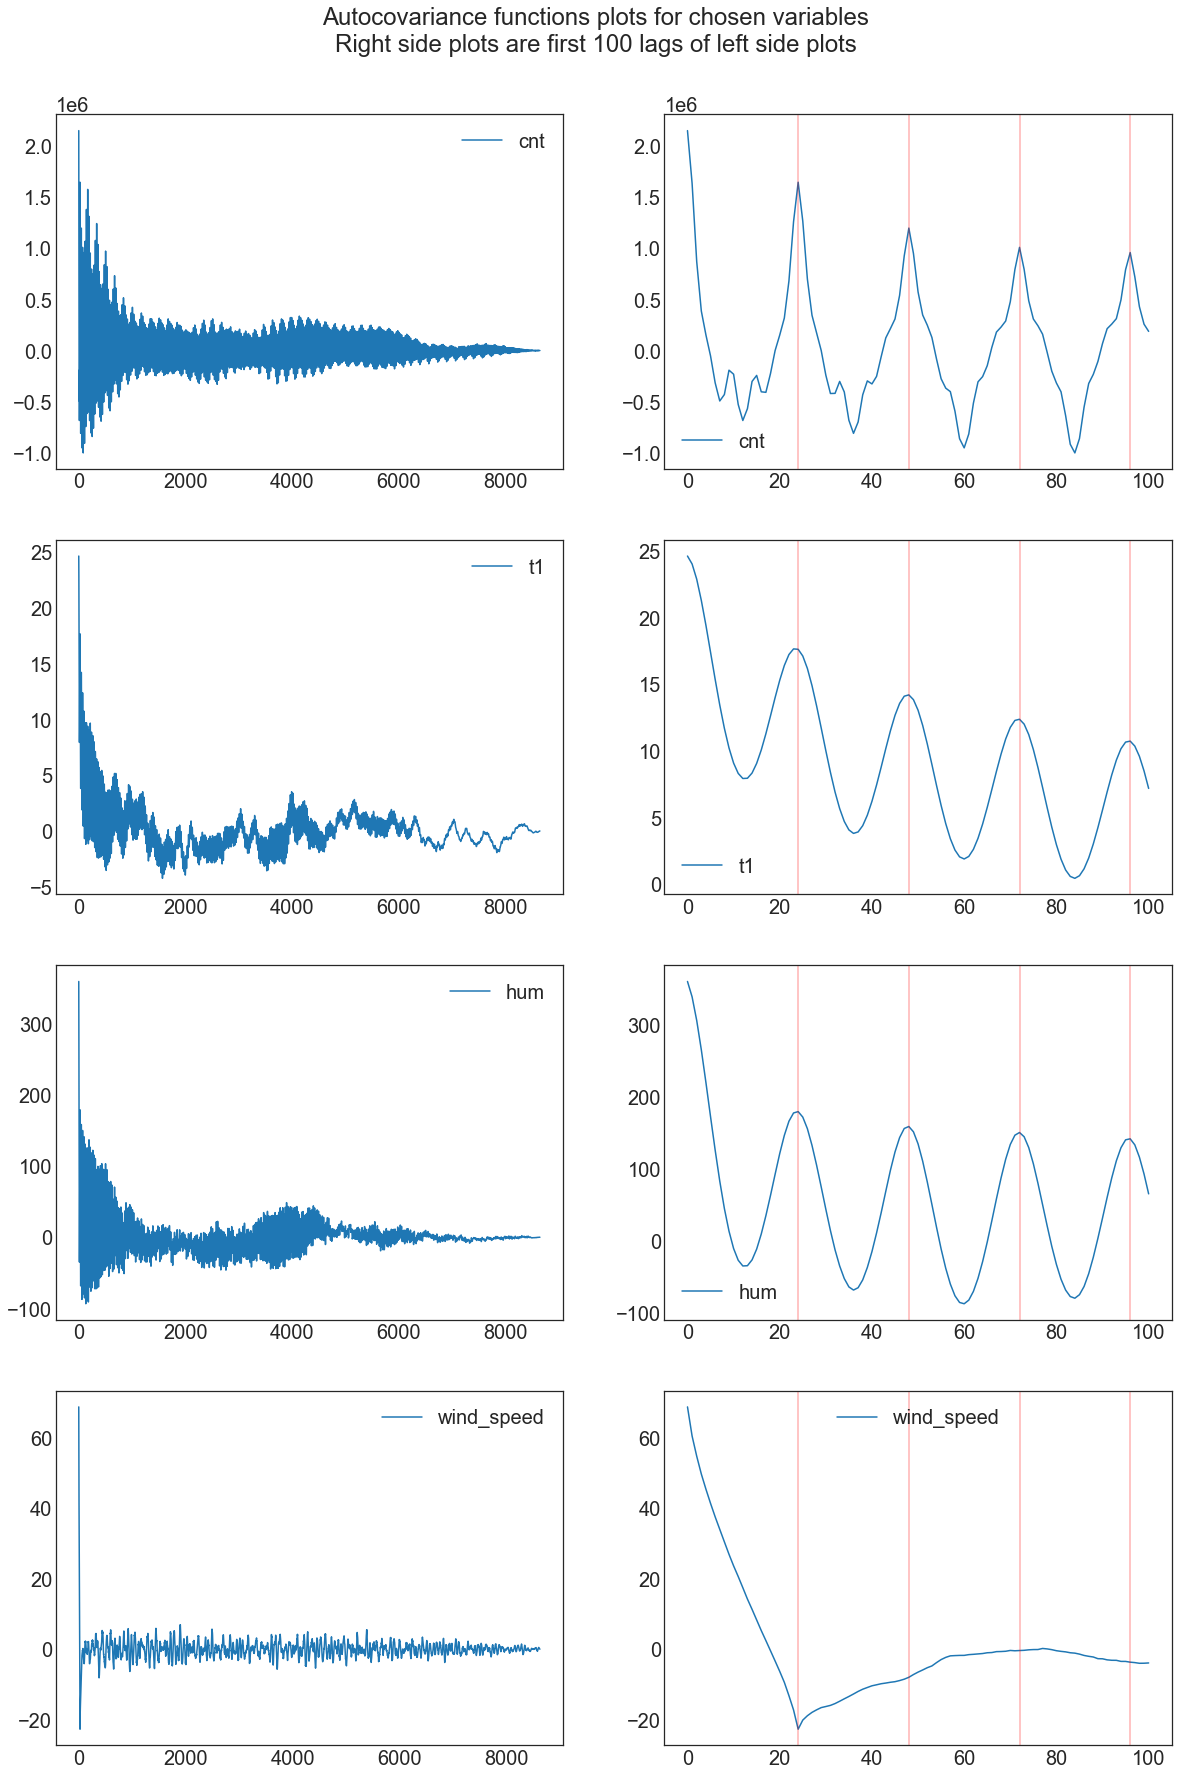

In [8]:
nlag = 100
_, axes = plt.subplots(nrows=len(chosen_vars), ncols=2, figsize=(20, 30))
plt.suptitle("Autocovariance functions plots for chosen variables\n"
             f"Right side plots are first {nlag} lags of left side plots", y=0.93)
for i, ax_row in enumerate(axes):
    plot_acovf(chosen_vars[i], ax1=ax_row[0], ax2=ax_row[1], nlag=nlag)

Analysis of the autocovariance functions shows that all chosen variables except for the last one have 24-hour seasonality.

In [9]:
def plot_target_filtered(series, ax):
    ax.plot(series, label='True series')
    ax.plot(filter1(series), label='First filtered series')
    ax.plot(filter2(series), label='Second filtered series')
    ax.title.set_text(series.name)
    ax.legend()

In [10]:
filter1 = lambda x: x.rolling(
    window=24, win_type='gaussian', min_periods=1, center=True).mean(std=1)
filter2 = lambda x: x.rolling(
    window=12, win_type='hamming', min_periods=1, center=True).mean()

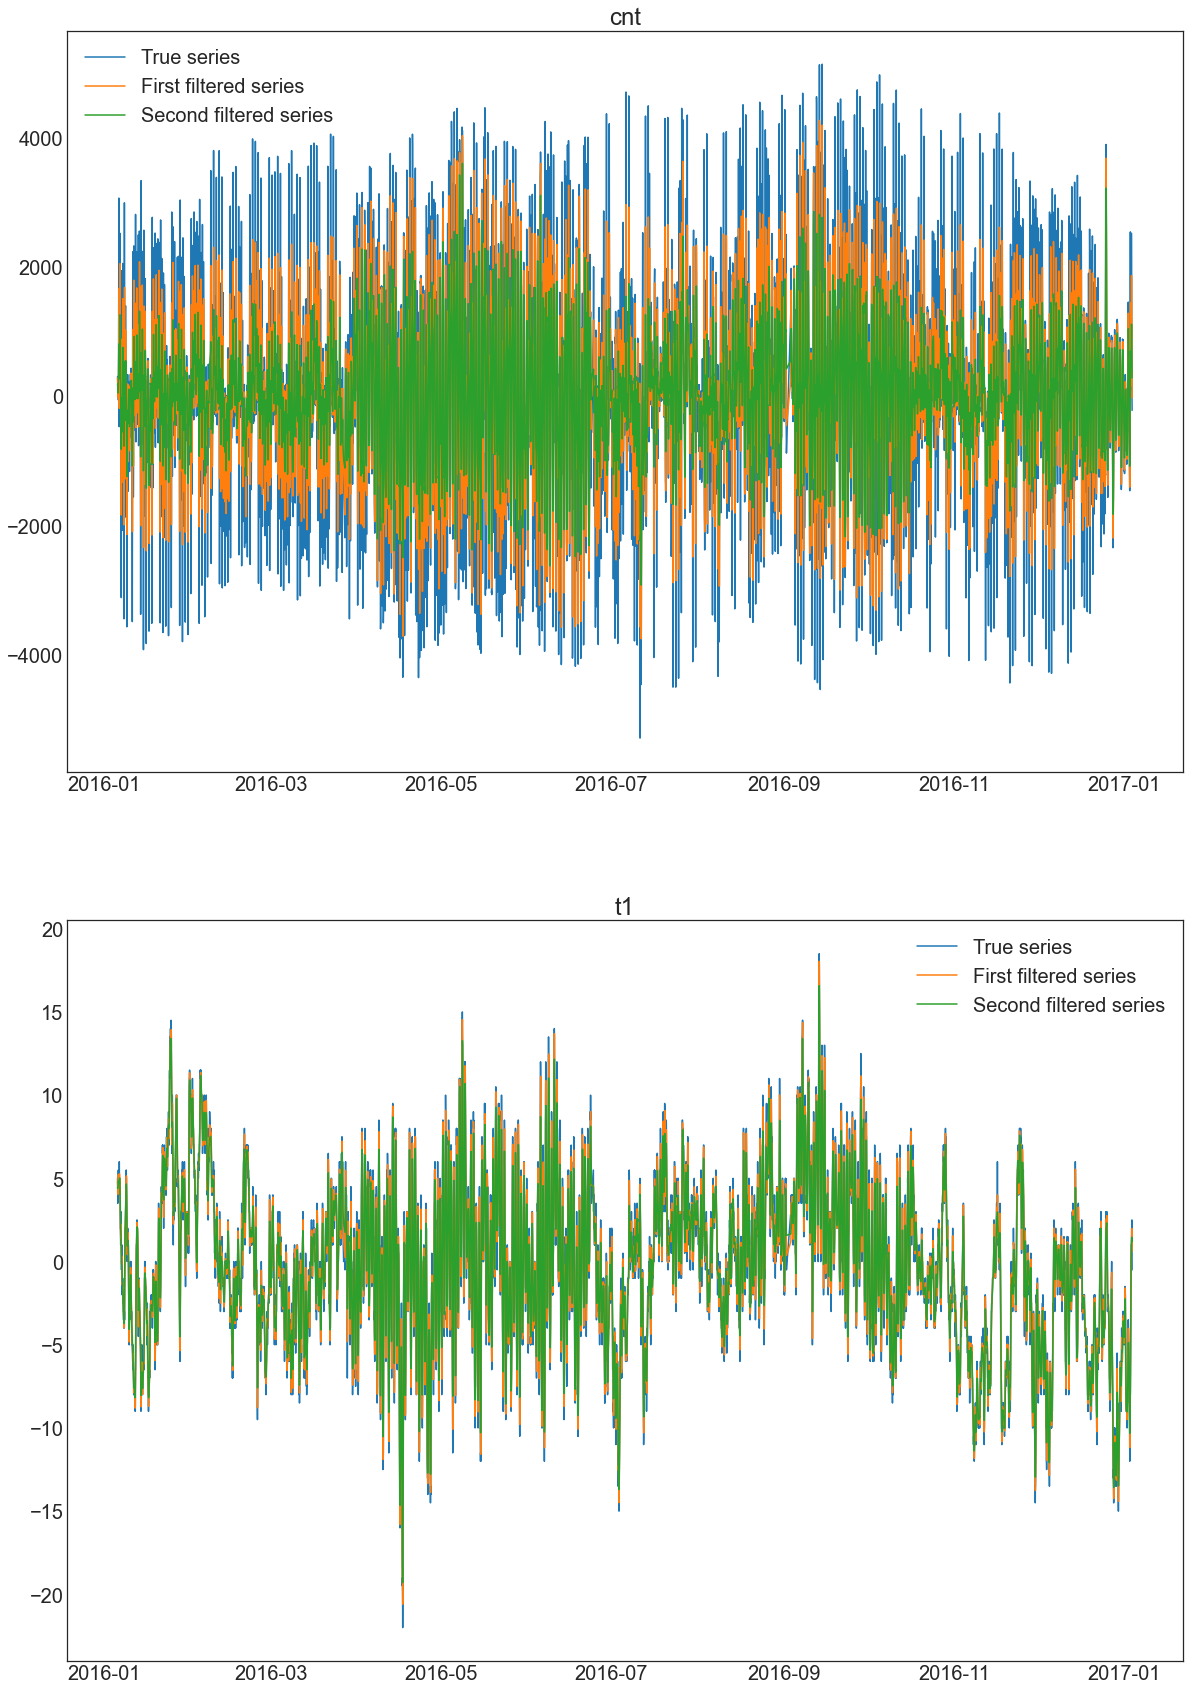

In [11]:
_, axes = plt.subplots(nrows=len(targets), figsize=(20, 30))
for i, ax in enumerate(axes.flatten()):
    plot_target_filtered(targets[i], ax=ax)

In [12]:
def plot_sdf(series, ax):
    f, pxx = signal.welch(series, nfft=1000, nperseg=200, scaling='spectrum')
    f_filt1, pxx_filt1 = signal.welch(filter1(series).dropna(), nfft=1000, nperseg=100, scaling='spectrum')
    f_filt2, pxx_filt2 = signal.welch(filter2(series).dropna(), nfft=1000, nperseg=100, scaling='spectrum')
    ax.plot(f, pxx, linewidth=3, label='True series')
    ax.plot(f_filt1, pxx_filt1, label='First filtered series')
    ax.plot(f_filt2, pxx_filt2, label='Second filtered series')
    ax.title.set_text(series.name)
    ax.legend()

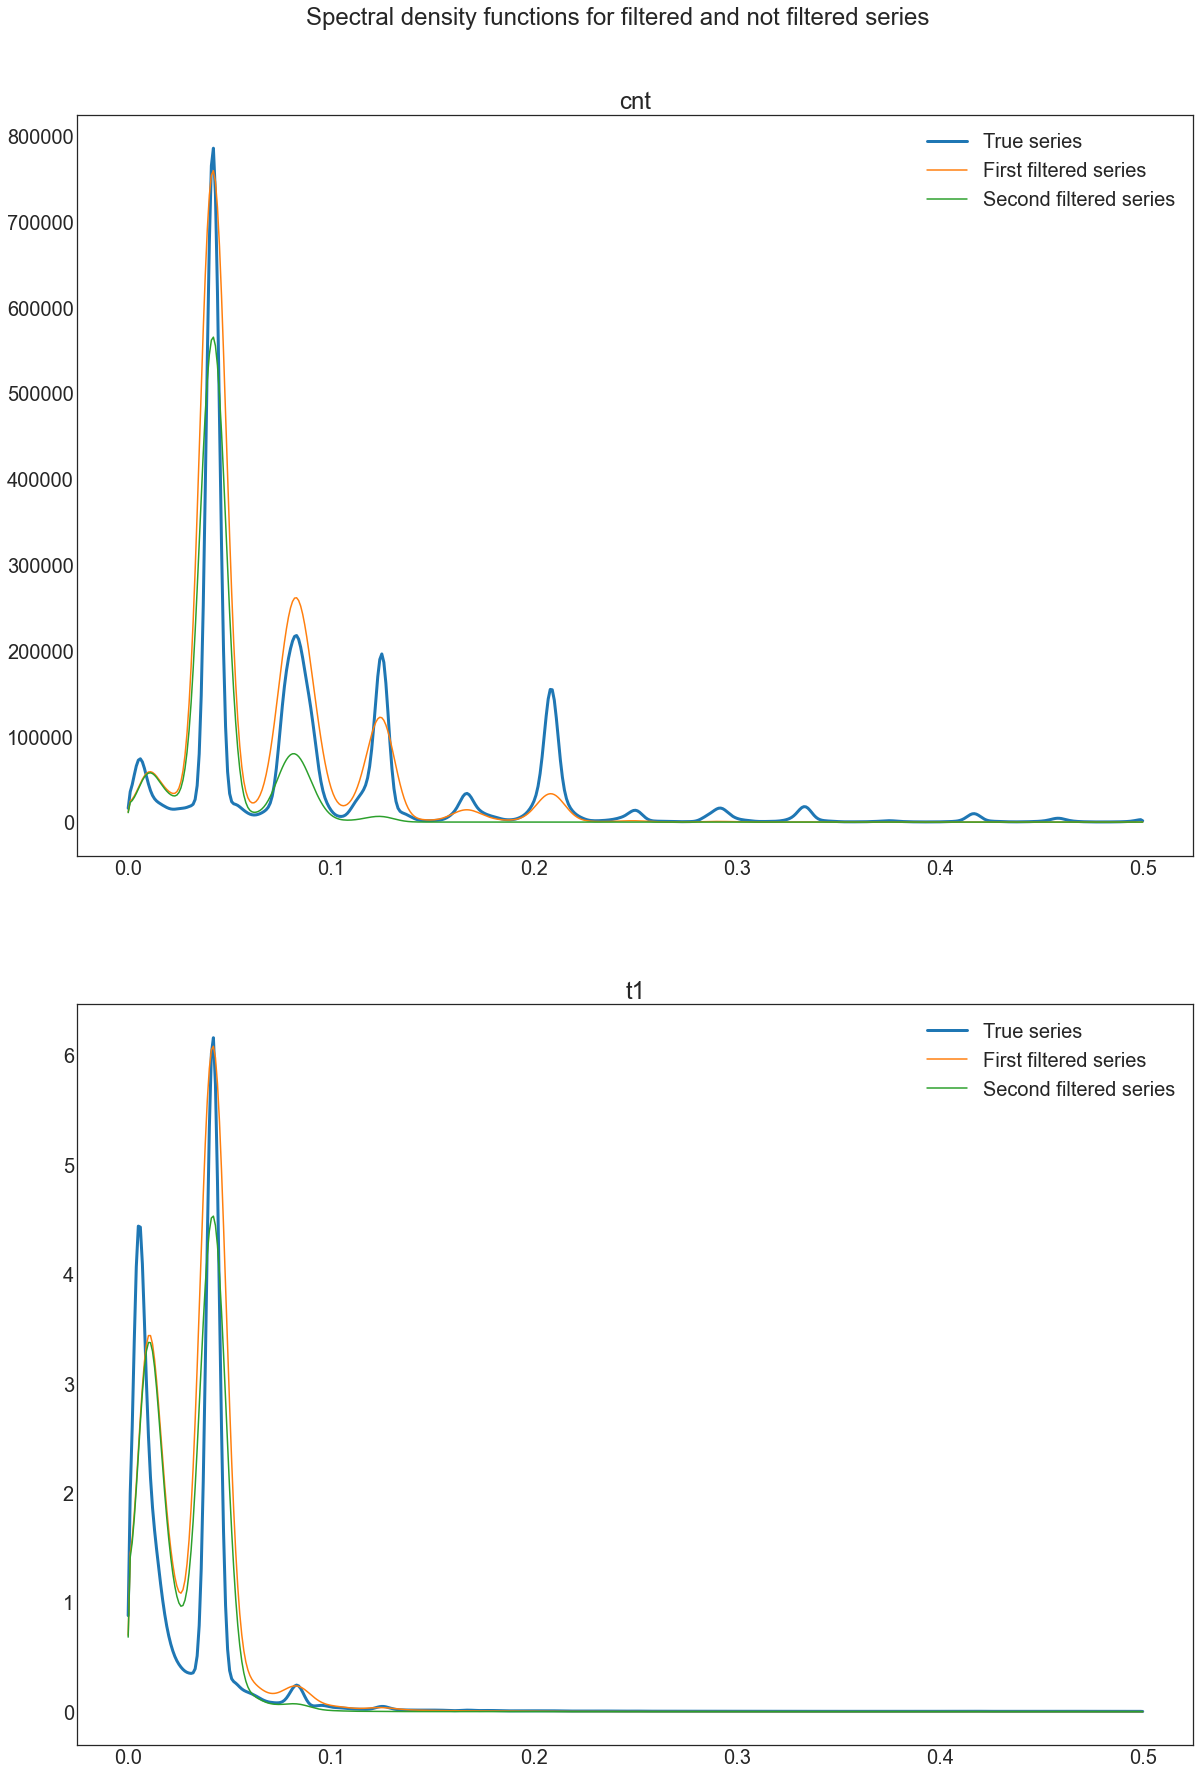

In [13]:
# Estimating spectral density function for with and without filtering
_, axes = plt.subplots(nrows=len(targets), figsize=(20, 30))
plt.suptitle("Spectral density functions for filtered and not filtered series", y=0.93)
for i, ax in enumerate(axes.flatten()):
    plot_sdf(targets[i], ax=ax)

In [83]:
def arima_model_selection(series_train, params):
    results = []
    best_err = np.inf
    for param in tqdm(params):
        #try except for the case of wrong parameters
        try:
            model = smt.ARIMA(series_train, order=(param[0], 0, param[1])).fit()
        except ValueError:
                continue
        error = np.abs(model.forecasts_error).sum()

        # save best model, error, parameters
        if (error < best_err):
            best_model = model
            best_err = error
            best_param = param
        results.append([param, error])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'error']
    print(result_table.sort_values(by = 'error', ascending=True).head())
    return best_model

In [76]:
ps = range(0, 25)
qs = range(0, 1)
parameters = product(ps, qs)
parameters_list = list(parameters)
print (u"Models to analyse by MAE:", len(parameters_list))

Models to analyse by MAE: 25


In [102]:
# finding and fitting best AR model for not filtered cnt series 
series = targets[0].dropna().copy()
series_train, series_test = train_test_split(
    series, train_size=500, shuffle=False, random_state=42
)
best_model_cnt = arima_model_selection(series_train, parameters_list)

  0%|          | 0/25 [00:00<?, ?it/s]

   parameters          error
24    (24, 0)  180040.984487
23    (23, 0)  185142.668876
22    (22, 0)  209028.827322
21    (21, 0)  216285.008365
20    (20, 0)  223441.210170


In [103]:
# finding and fitting best AR model for filtered cnt series 
series_train_filt, series_test_filt = train_test_split(
    filter1(series).dropna(), train_size=500, shuffle=False, random_state=42
)
best_model_filt_cnt = arima_model_selection(series_train_filt, parameters_list)

  0%|          | 0/25 [00:00<?, ?it/s]

   parameters         error
23    (23, 0)  36561.044713
24    (24, 0)  36596.250595
22    (22, 0)  37045.345155
21    (21, 0)  37343.365224
20    (20, 0)  41541.986943


In [91]:
# finding and fitting best AR model for not filtered t1 series 
series = targets[1].dropna().copy()
series_train, series_test = train_test_split(
    series, train_size=500, shuffle=False, random_state=42
)
best_model_t1 = arima_model_selection(series_train, parameters_list)

  0%|          | 0/25 [00:00<?, ?it/s]

   parameters       error
23    (23, 0)  291.527262
24    (24, 0)  292.226187
22    (22, 0)  294.625575
21    (21, 0)  294.649086
20    (20, 0)  295.476500


In [95]:
# finding and fitting best AR model for filtered t1 series 
series_train_filt, series_test_filt = train_test_split(
    filter2(series).dropna(), train_size=500, shuffle=False, random_state=42
)
best_model_filt_t1 = arima_model_selection(series_train_filt, parameters_list)

  0%|          | 0/25 [00:00<?, ?it/s]

   parameters      error
24    (24, 0)  12.805050
23    (23, 0)  12.827484
22    (22, 0)  12.868633
21    (21, 0)  12.911242
20    (20, 0)  12.982087


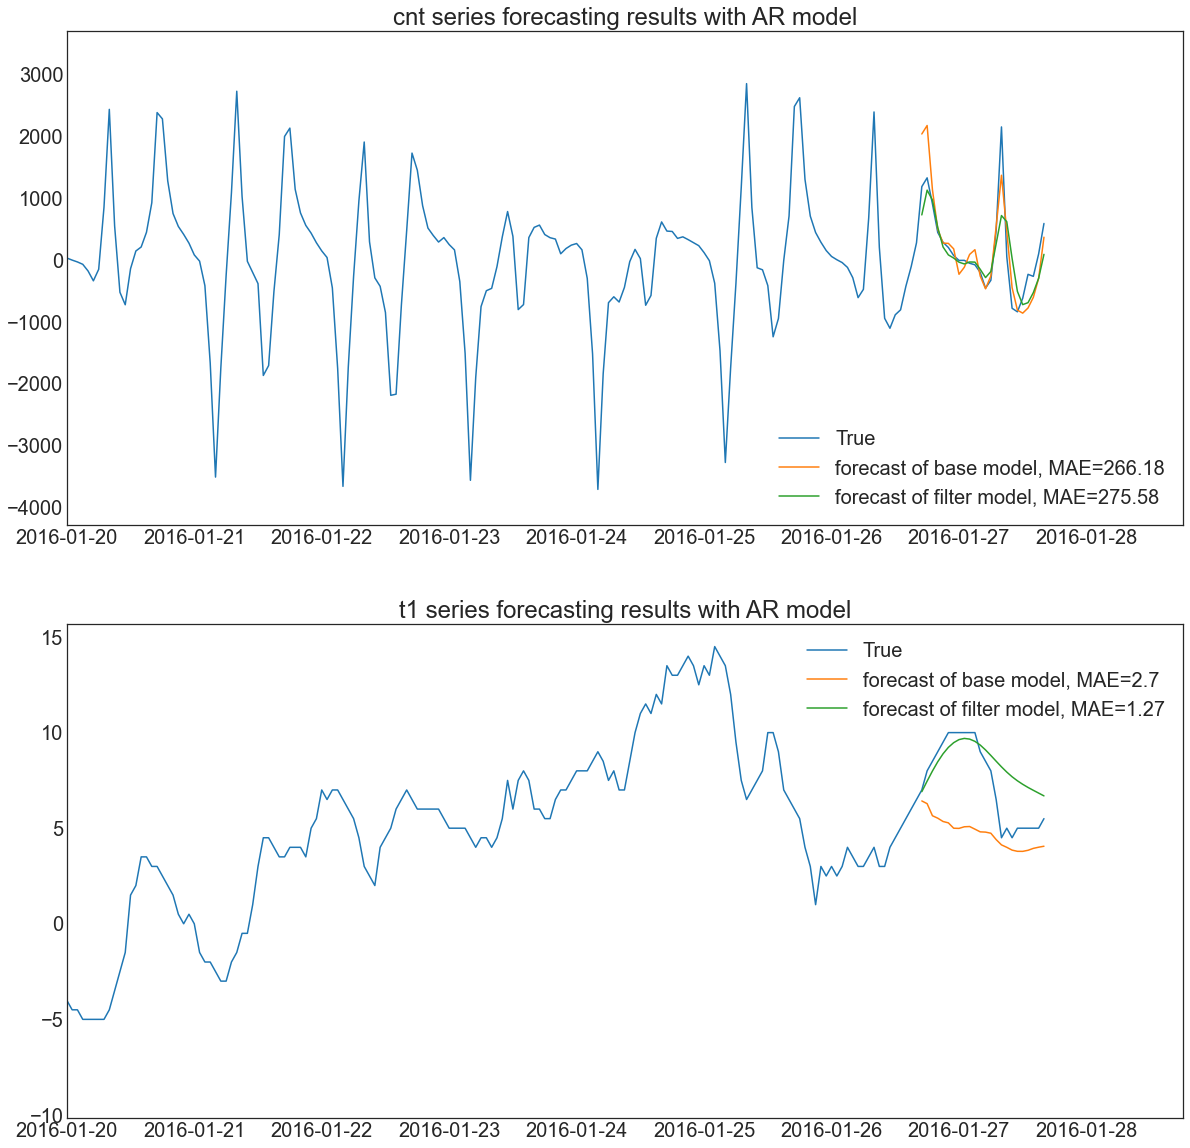

In [104]:
forecast_len = 24
pred = [0] * 2
pred_filt = [0] * 2
pred[0] = best_model_cnt.forecast(forecast_len)
pred_filt[0] = best_model_filt_cnt.forecast(forecast_len)
pred[1] = best_model_t1.forecast(forecast_len)
pred_filt[1] = best_model_filt_t1.forecast(forecast_len)

_, axes = plt.subplots(nrows=2)
for i, ax in enumerate(axes):
    ax.plot(targets[i].iloc[:len(series_train) + forecast_len], label='True')
    ax.plot(pred[i], 
            label=f'forecast of base model, MAE={round(mae(targets[i].loc[pred[i].index], pred[i]), 2)}')
    ax.plot(pred_filt[i], 
            label=f'forecast of filter model, MAE={round(mae(targets[i].loc[pred_filt[i].index], pred_filt[i]), 2)}')
    ax.title.set_text(targets[i].name + " series forecasting results with AR model")
    ax.set_xlim(dt.datetime(2016, 1, 20, 0))
    ax.legend()

In [80]:
var_target = pd.DataFrame(data=[chosen_vars[0], chosen_vars[1]]).T
var_exog = pd.DataFrame(data=[chosen_vars[2], chosen_vars[3]]).T

var_target_train, var_target_test, var_exog_train, var_exog_test = train_test_split(
    var_target, var_exog, train_size=500, shuffle=False, random_state=42
)

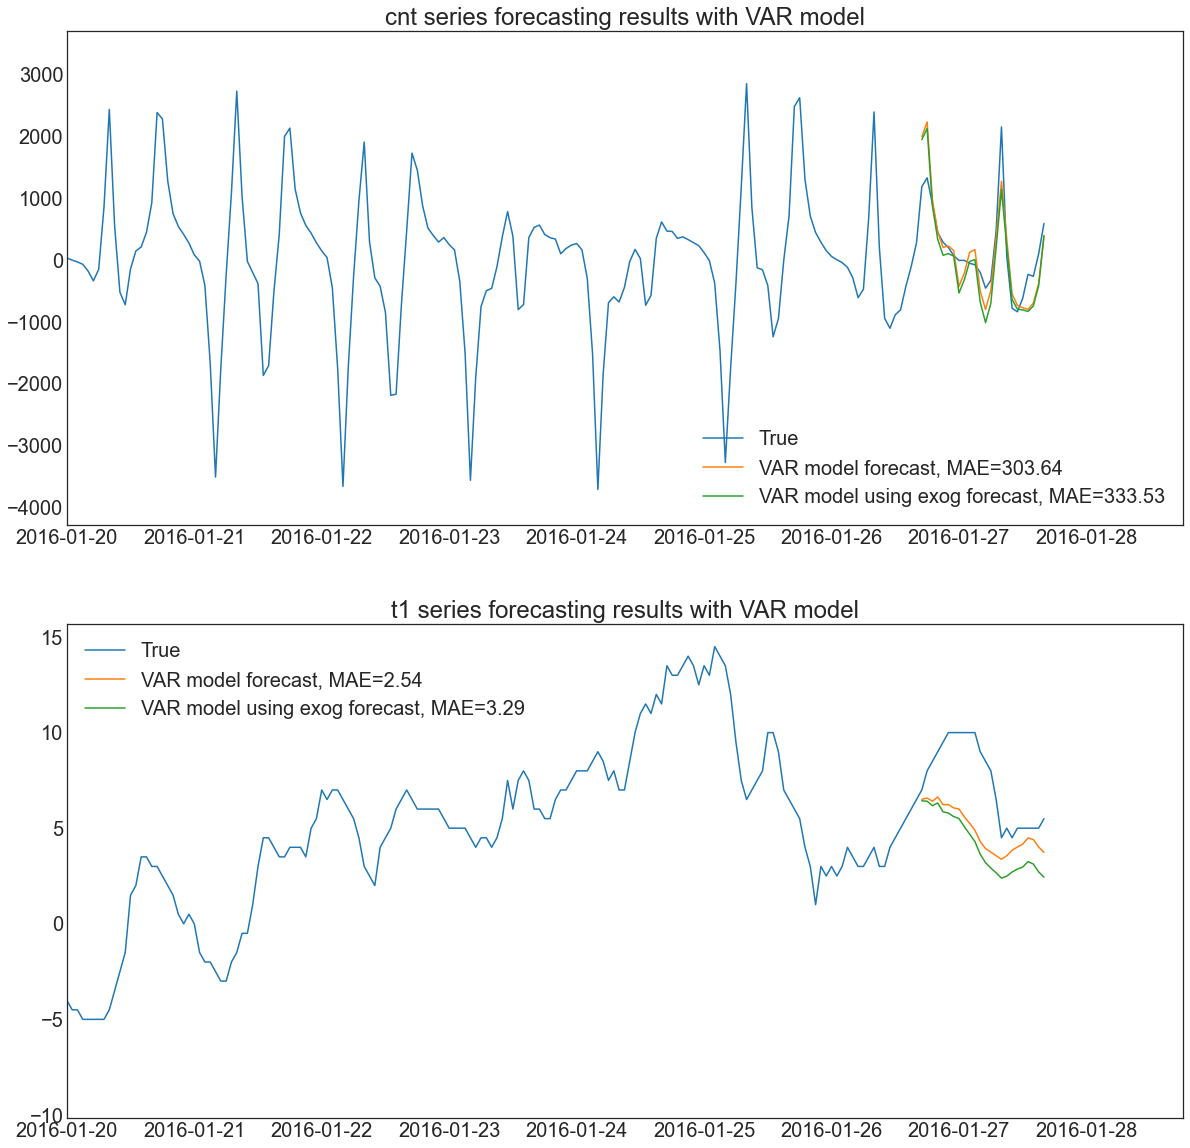

In [86]:
# VAR model automatically finds best order using OLS method
# I just set maxlags to limit max order
forecast_len = 24
maxlags=24

var_model = VAR(var_target_train).fit(maxlags=maxlags)
var_pred = var_model.forecast(var_target_train[-maxlags:].values, steps=forecast_len)

var_model_exog = VAR(var_target_train, exog=var_exog_train).fit(maxlags=maxlags)
var_pred_exog = var_model_exog.forecast(
    var_target_train[-maxlags:].values, 
    steps=forecast_len,
    exog_future=var_exog_test[:forecast_len]
)

_, axes = plt.subplots(nrows=2)
for i, ax in enumerate(axes):
    true_values = var_target.iloc[:len(var_target_train) + forecast_len, i]
    ax.plot(true_values, label='True')
    ax.plot(var_target_test[:forecast_len].index, var_pred[:, i], 
            label=f'VAR model forecast, MAE={round(mae(true_values[-forecast_len:], var_pred[:, i]), 2)}')
    ax.plot(var_target_test[:forecast_len].index, var_pred_exog[:, i], 
            label=f'VAR model using exog forecast, MAE={round(mae(true_values[-forecast_len:], var_pred_exog[:, i]), 2)}')
    ax.title.set_text(true_values.name + " series forecasting results with VAR model")
    ax.set_xlim(dt.datetime(2016, 1, 20, 0))
    ax.legend()